In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from optuna.visualization.matplotlib import  plot_slice
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

/Users/leamargery/Documents/ing2/ftml/FTML-Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Data

In [2]:
PATH_DATA = "data/"
X_train = np.load(os.path.join(PATH_DATA, "X_train.npy"))
X_test = np.load(os.path.join(PATH_DATA, "X_test.npy"))
y_train = np.load(os.path.join(PATH_DATA, "y_train.npy"))
y_test = np.load(os.path.join(PATH_DATA, "y_test.npy"))

X_train.shape, y_test.shape, X_test.shape, y_test.shape

((500, 30), (500,), (500, 30), (500,))

### Visualizing Data

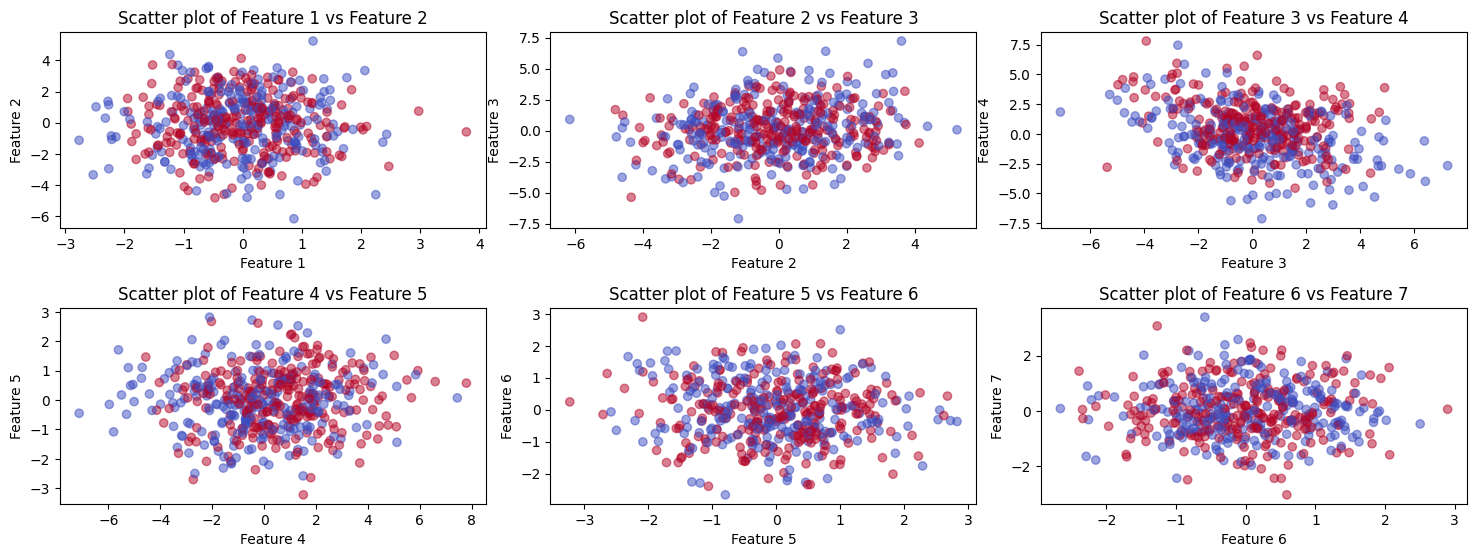

In [3]:
plt.figure(figsize=(15, 8))
for i in range(1, 7):
    plt.subplot(3, 3, i)
    plt.scatter(X_train[:, i], X_train[:, i+1], c=y_train, cmap='coolwarm', alpha=0.5)
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'Feature {i+1}')
    plt.title(f'Scatter plot of Feature {i} vs Feature {i+1}')
plt.tight_layout()
plt.show()

### Data seems non linear
Just by looking at a few features, we can tell that the data is probably non-linear.\
If we want good results we may need to use a non linear classifier

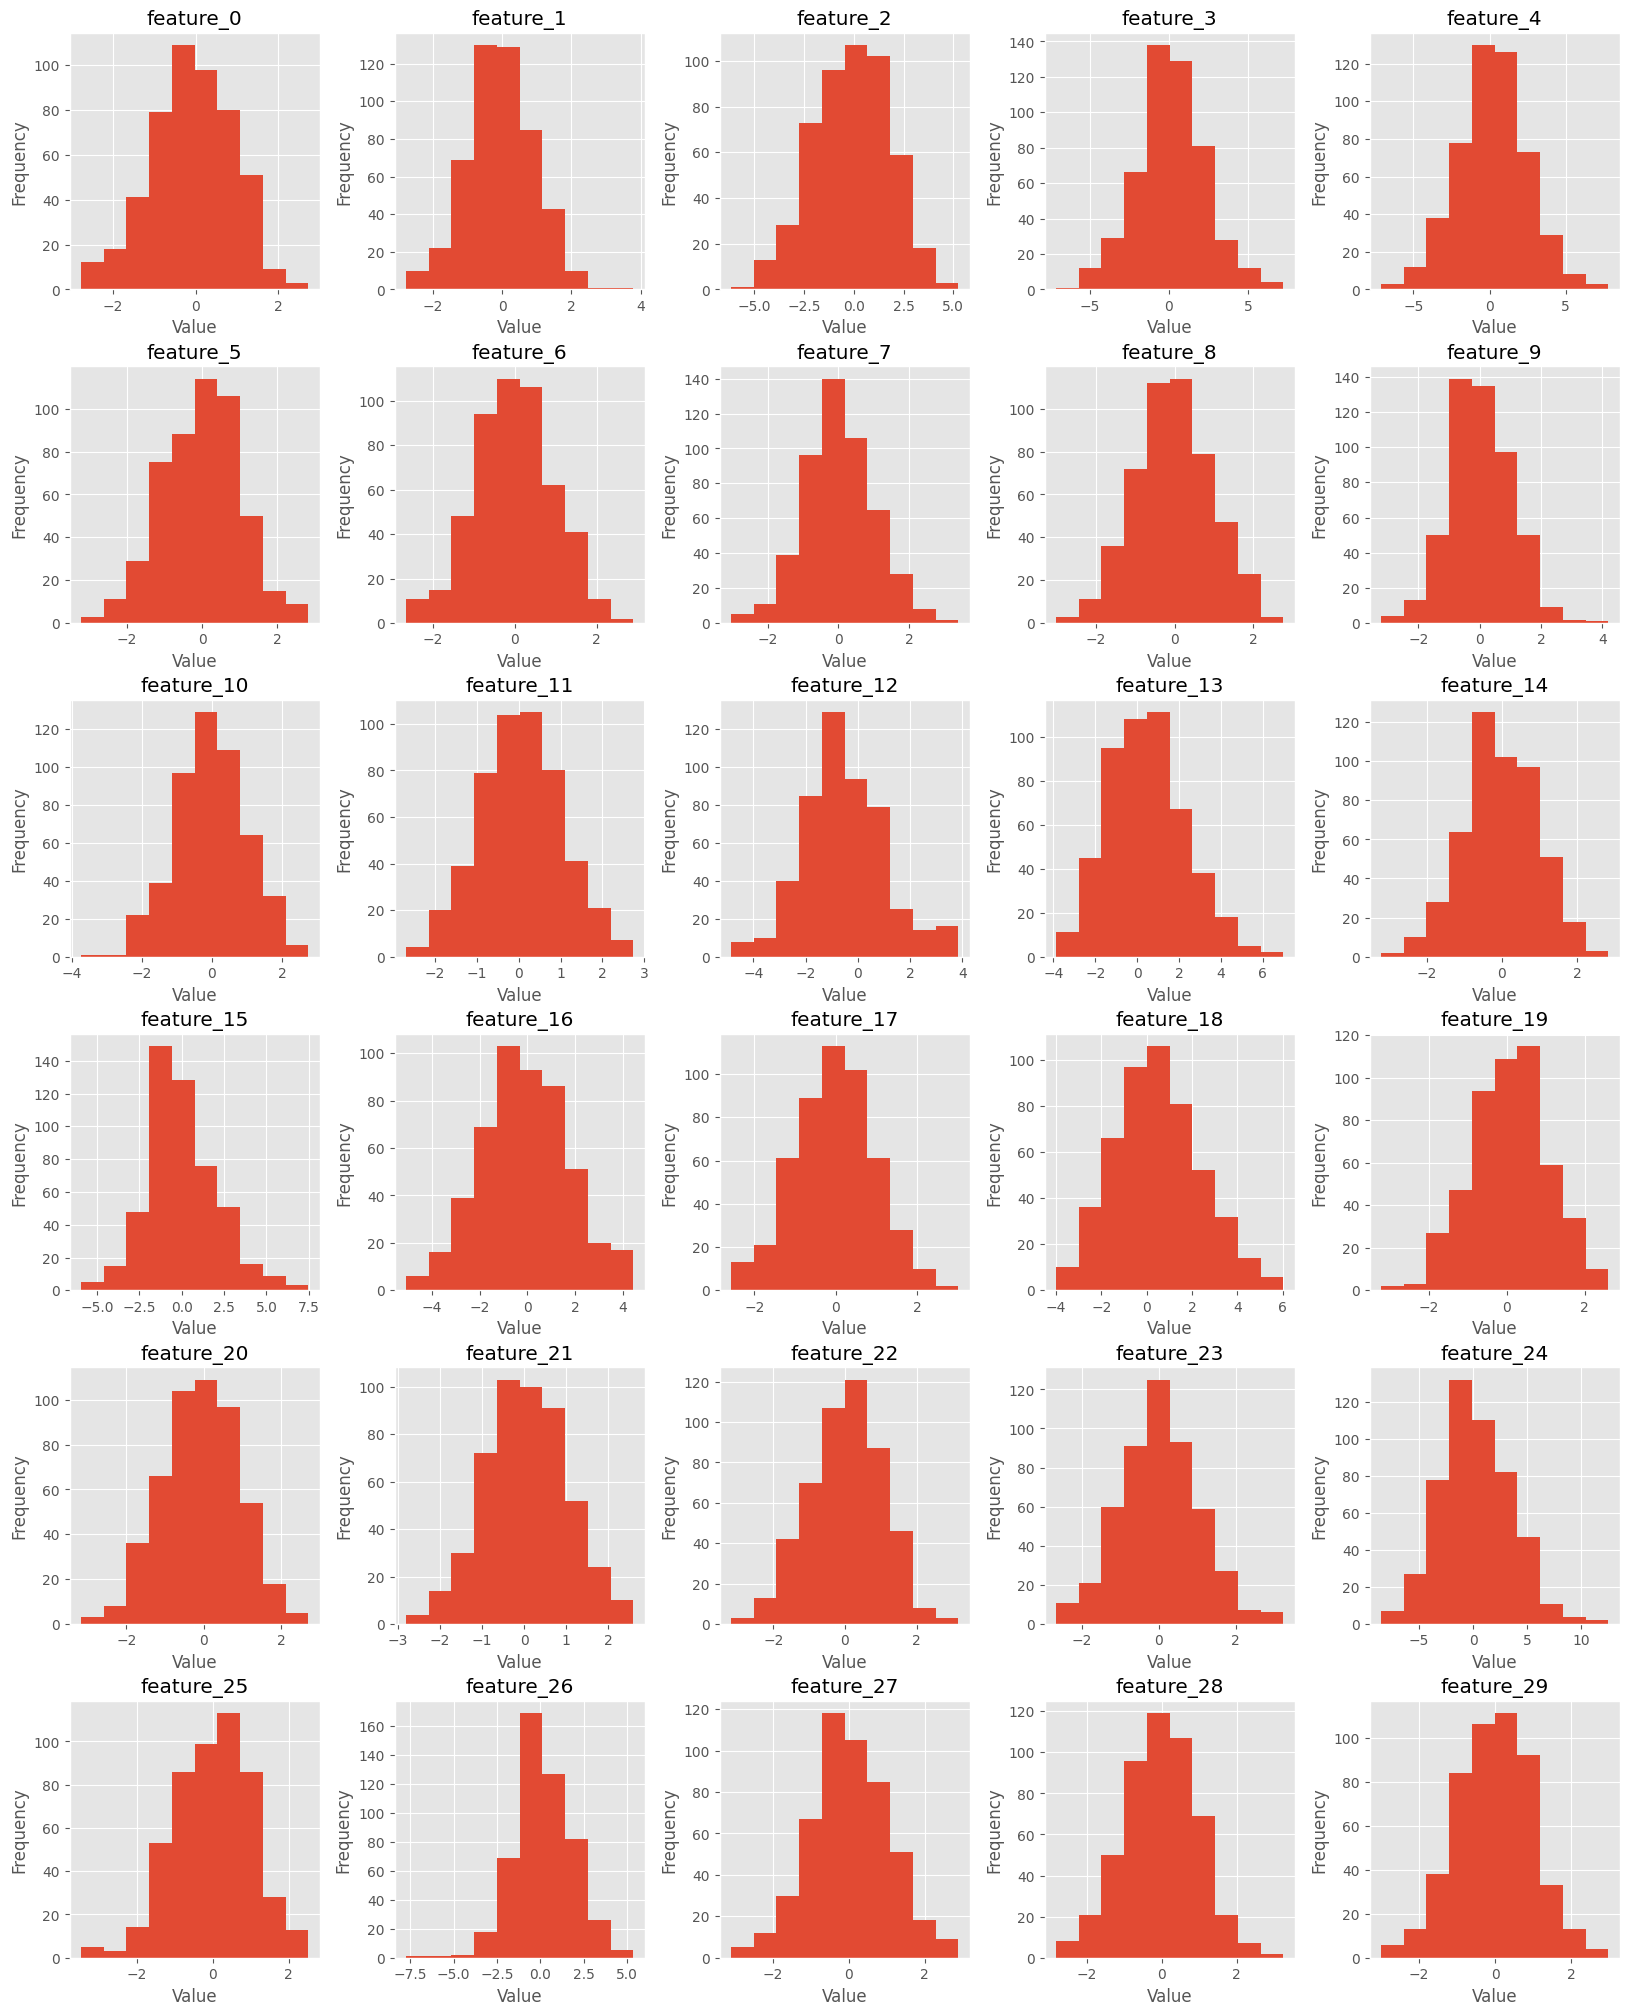

In [14]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
df = pd.DataFrame(X_train, columns=feature_names)

fig = df.hist(figsize=(20, 25))
for ax in fig.flatten():
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.show()

### Data distribution
The data seems to follow a gaussian distribution There is probably no point to normalize our values

### Feature Engineering


We test a simple regression model but adding polynomial features since the relations bewteen the features is non linear


In [5]:
result_accuracy = []

def logistic_regression_model(result_accuracy, X_train, y_train, X_test, name):
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(X_train, y_train)
    y_pred_logistic = logistic_model.predict(X_test)
    logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
    result_accuracy.append([name, logistic_accuracy])

logistic_regression_model(result_accuracy, X_train, y_train, X_test, name="classic_logistic_reg")

for i in range(2, 5):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    logistic_regression_model(result_accuracy, X_train_poly, y_train, X_test_poly, name=f"poly_deg{i}_logistic_reg")


results_df = pd.DataFrame(result_accuracy, columns=["classifier", "accuracy_test"])
results_df

,classifier,accuracy_test
0,classic_logistic_reg,0.800
1,poly_deg2_logistic_reg,0.722
2,poly_deg3_logistic_reg,0.904
3,poly_deg4_logistic_reg,0.780


**We notice that the model is able to capture better non linear relationship to the degree of 3**

### Now Let's use a SVM with polynomial kernal and with the degree of 3 
#### Kernel Trick

We choose a SVC because it works well with many features and it's decision depends on the support vectors and not the number of features 

In [6]:
svm_classifier = SVC(kernel='poly', degree=3)

"""
 We use X_train and not X_train_poly because the model
 already uses a polynomial class boundry to maximize margins.
"""

svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       201
           1       0.84      0.93      0.88       299

    accuracy                           0.85       500
   macro avg       0.85      0.83      0.84       500
weighted avg       0.85      0.85      0.85       500



### Analyze results
We notice that the recall of model on the class 0 is 0.74\
we can try to play with the regularization so that it can learn better\
the training dataset or allow more margin violations and generelize better

#### Hyperparameter research
We are going to test the following hyperparameters:
- Regularization


In [7]:
def objective_SVM(trial: optuna.trial.Trial):
    t_C = trial.suggest_float("C", 0.1, 15, step=0.02)
    
    svm_classifier = SVC(
        C=t_C,
        kernel="poly",
    ) 
    
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [8]:
storage_name = "classification.db"
if os.path.exists(storage_name):
    os.remove(storage_name)

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Classification",
        load_if_exists=False,
        direction="maximize",
)

study.optimize(func=objective_SVM, n_trials=100)

In [9]:
print(f"Best obtrained accuracy: {study.best_trial.values}\nWith the following parameters: {study.best_trial.params}" )

Best obtrained accuracy: [0.986]
With the following parameters: {'C': 10.959999999999999}


/var/folders/m9/t21_dzvj3cj5wcthr1068wp80000gn/T/ipykernel_4697/2457830863.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


<Axes: title={'center': 'Slice Plot'}, xlabel='C', ylabel='Objective Value'>

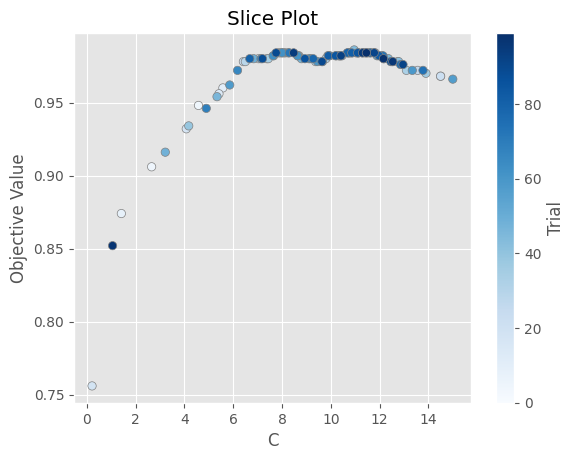

In [10]:
plot_slice(study)

### Let's try to explain our results?

**REGULARIZATION**

Regularization plays an important role in the decision boundry of our SVC.
We notice that the higher the C parameter, the better our model performs.

- Knowing that we have 30 features, we need a complexe model to better classify our data.
- A high value of C means less regularization, leading the model to aim for minimizing the training error.

The decision boundary will be more complex and fit a bit more the training data.

We choose a C of around 11 which represents a smaller regularization in order\
to better capture the complex relations of our dataset 


### Comparaison

We have compared two models :
- Logistic regression
- SVC 


With the logistic regression model we noticed that if the data was raw we would obtain a low accuracy on the test set. So feature engineering was the approach we chose to break linearity of the model. We noticed that a third degree of a polynomial was appropriate for logistic regression and we achieved 0.904 mean accuracy on a test set. 
We then tried SVC with a kernel polynomial and a degree three and we achievec 0.85 of mean accuracy on the test set and we decided to optimise the model simply by testing differente value of regularisation